In [144]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy.fft as fft

In [145]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)

cpu


In [146]:
num_frames = 100

num_alphas = 10
alphlowlim = 0.0
alphhighlim = 0.9
num_ds = 50
dlowlim = 0.0
dhighlim = 4.9

In [147]:
alpha_vals = np.linspace(alphlowlim, alphhighlim, num_alphas)
print(alpha_vals)
alpha_vals[0] = 1e-10 # set alpha=0 to a small value

d_vals = np.linspace(dlowlim, dhighlim, num_ds)
print(d_vals)
d_vals[0] = 1e-10 # set d=0 to a small value


r_vals = np.linspace(0.0, 10.0, 501)
r_vals = r_vals[:-1]
r_vals[0] = 1e-10 # set r=0 to a small value

k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
k_vals = fft.fftshift(k_vals)

# convert to tensor
r_vals = torch.from_numpy(r_vals).float().to(device)


# print the shape of the data
print(f"shape of alpha_vals : {alpha_vals.shape}")
print(f"shape of d_vals : {d_vals.shape}")

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]
shape of alpha_vals : (10,)
shape of d_vals : (50,)


In [148]:
# initial guess for P_alpha_d
P_alpha_d = np.zeros((num_frames, num_alphas, num_ds))
# for i in range(num_frames):
#     P_alpha_d[i, 0, 0] = 1.0


alpha0 = 0.2
d0 = 2.5
for i in range(num_alphas):
    for j in range(num_ds):
        P_alpha_d[:, i, j] = np.exp(-((alpha_vals[i] - alpha0)**2 + (d_vals[j] - d0)**2) / 0.1)

# # normalize P_alpha_d
P_alpha_d = P_alpha_d / np.trapz(np.trapz(P_alpha_d, x=d_vals, axis=2), x=alpha_vals, axis=1)[:, None, None]
# P_alpha_d = P_alpha_d / np.sum(P_alpha_d, axis=(1, 2))[:, None, None]


# convert to tensor
alpha_vals = torch.from_numpy(alpha_vals).float().to(device)
# convert to tensor
d_vals = torch.from_numpy(d_vals).float().to(device)
# convert to tensor
k_vals = torch.from_numpy(k_vals).float().to(device)

# convert P_alpha_d to torch tensor
P_alpha_d = torch.tensor(P_alpha_d, dtype=torch.float32, device=device, requires_grad=True)
# restrict P_alpha_d to be positive while training
# P_alpha_d = torch.clamp(P_alpha_d, min=0.0)
# print(P_alpha_d)

In [149]:
def contour_plt(P_alpha_d, i=0):
    """
    Visualise P_alpha_d as a countour plot using contourf
    """
    # plot
    # rescale the y axis to be in the range of 0 to 2
    # rescale the x axis to be in the range of 0 to 1000
    # check if P_alpha_d is a torch tensor
    if isinstance(P_alpha_d, torch.Tensor):
        P_alpha_d_copy = P_alpha_d.detach().cpu().numpy()
    else:
        P_alpha_d_copy = P_alpha_d.copy()
    plt.figure(figsize=(4, 4))
    x = np.linspace(dlowlim, dhighlim, num_ds)
    y = np.linspace(alphlowlim, alphhighlim, num_alphas)
    plt.contourf(x, y, P_alpha_d_copy[i], 20, cmap='RdGy')
    plt.xlabel('d')
    plt.ylabel('alpha')
    plt.colorbar()
    plt.show()

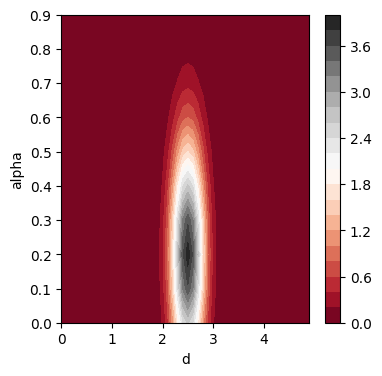

In [150]:
# # visualize P_alpha_d inital in subplots
# for i in range(num_frames):
#     contour_plt(P_alpha_d, i)
contour_plt(P_alpha_d, 50)

In [151]:
# load u_pred
u = np.loadtxt("u.txt")
print(f"shape of u : {u.shape}")
# print(u_pred)
# convert to torch tensor
u = torch.tensor(u, dtype=torch.float32, device=device)
print(f"shape of u : {u.shape}")

shape of u : (100, 500)
shape of u : torch.Size([100, 500])


In [152]:
# load Z
Z = np.load("Z.npy")
print(f"shape of Z : {Z.shape}")
# convert Z to torch tensor
Z = torch.from_numpy(Z).float().to(device)
# print shape of Z
print(f"shape of Z : {Z.shape}")
# print(Z)
# normalize Z to have integral of Z over r equal to 1
# Z = Z / np.sum(Z * (r_vals[1]-r_vals[0]))
# print(Z)

shape of Z : (10, 50, 100, 500)
shape of Z : torch.Size([10, 50, 100, 500])


In [153]:
def give_u_pred(P_alpha_d, Z, alpha_vals, d_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = torch.zeros((num_frames, len(r_vals)))
    # move u_pred to device
    u_pred = u_pred.to(device)

    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            integrand = torch.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals)
            u_pred[i, j] = torch.trapz(integrand, alpha_vals)

    # normalize u_pred
    # u_pred = u_pred / (u_pred.sum(dim=1, keepdim=True) + 1e-9)
    # u_pred = u_pred / (torch.trapz(u_pred, k_vals, dim=1, keepdim=True) + 1e-9)
    
    # norm = (torch.trapz(u_pred, k_vals, dim=1))

    # u_pred = u_pred / norm[:, None]


    return u_pred    

In [154]:
# manual loss function
def loss_function(P_alpha_d, u, Z, alpha_vals, d_vals):
    # clamp P_alpha_d to be positive
    # P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)
    # normalize P_alpha_d
    norm = (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1))
    P_alpha_d = P_alpha_d / norm[:, None, None]
    # P_alpha_d = P_alpha_d / (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1, keepdim=True) + 1e-6)
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True))
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True) + 1e-6)
    # calculate u_pred using double integral
    u_pred = give_u_pred(P_alpha_d, Z, alpha_vals, d_vals)
    # calculate loss
    loss = torch.sum((u_pred - u)**2)
    # loss /= u.shape[0] * u.shape[1]
    # loss = torch.sum(abs(u_pred - u))

    return loss

In [155]:
# write a function to train the model
def train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=100, lr=1e-1):
    # define the optimizer
    optimizer = torch.optim.Adam([P_alpha_d], lr=lr)
    # define the loss function
    loss_func = loss_function
    # define the loss history
    loss_history = []
    # train the model
    for epoch in range(num_epochs):
        # calculate loss
        loss = loss_func(P_alpha_d, u, Z, alpha_vals, d_vals)
        # zero the gradients
        optimizer.zero_grad()
        # backpropagate
        loss.backward()
        # update parameters
        optimizer.step()
        # append loss to loss history
        loss_history.append(loss.item())
        P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)

        # plot P_alpha_d
        if (epoch+1) % 5 == 0:
            contour_plt(P_alpha_d, 50)
        # print loss
        if (epoch+1) % 1 == 0:
            print(f"epoch {epoch+1} / {num_epochs} : loss = {loss.item()}")
    # plot loss history
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return P_alpha_d

epoch 1 / 500 : loss = 1242.34375
epoch 2 / 500 : loss = 1145.475830078125
epoch 3 / 500 : loss = 1082.9813232421875
epoch 4 / 500 : loss = 1037.387451171875


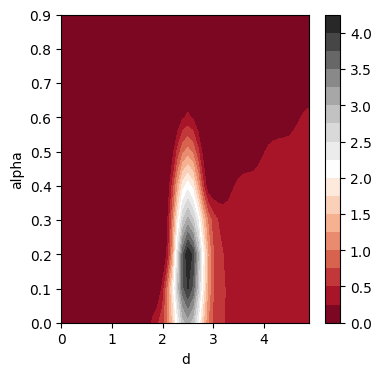

epoch 5 / 500 : loss = 1002.62109375
epoch 6 / 500 : loss = 974.2809448242188
epoch 7 / 500 : loss = 950.4169311523438
epoch 8 / 500 : loss = 929.871826171875
epoch 9 / 500 : loss = 912.1600952148438


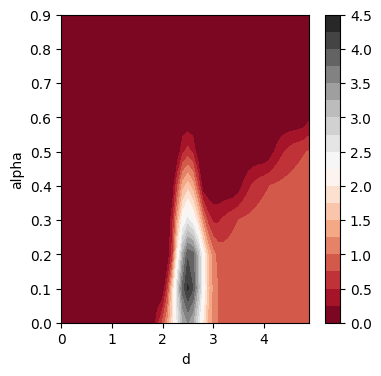

epoch 10 / 500 : loss = 896.5916748046875
epoch 11 / 500 : loss = 882.3593139648438
epoch 12 / 500 : loss = 869.23583984375
epoch 13 / 500 : loss = 857.2853393554688
epoch 14 / 500 : loss = 845.9754028320312


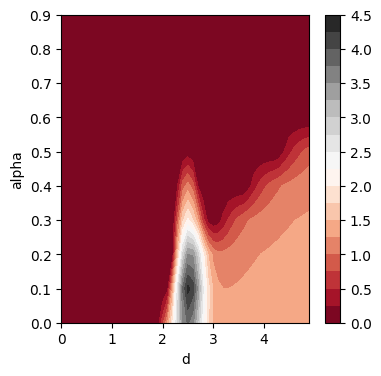

epoch 15 / 500 : loss = 835.2307739257812
epoch 16 / 500 : loss = 825.2640991210938
epoch 17 / 500 : loss = 816.0050659179688
epoch 18 / 500 : loss = 807.3246459960938
epoch 19 / 500 : loss = 798.9901123046875


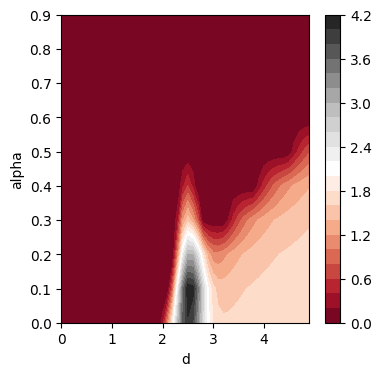

epoch 20 / 500 : loss = 791.0357055664062
epoch 21 / 500 : loss = 783.3936157226562
epoch 22 / 500 : loss = 775.9306030273438
epoch 23 / 500 : loss = 768.5927734375
epoch 24 / 500 : loss = 761.3572387695312


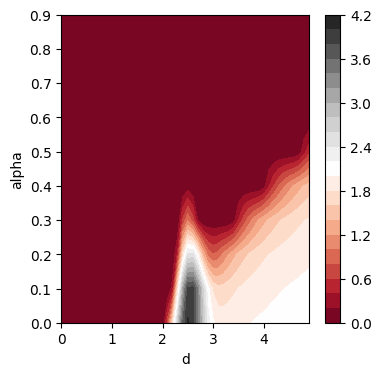

epoch 25 / 500 : loss = 754.312744140625
epoch 26 / 500 : loss = 747.7590942382812
epoch 27 / 500 : loss = 741.49755859375
epoch 28 / 500 : loss = 735.5552368164062
epoch 29 / 500 : loss = 729.8671875


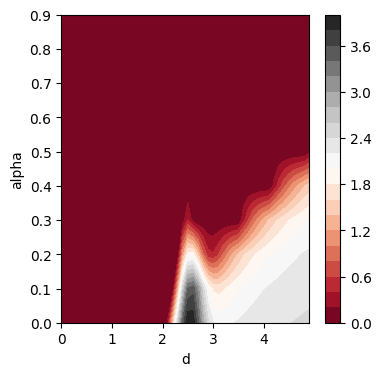

epoch 30 / 500 : loss = 724.3734741210938
epoch 31 / 500 : loss = 718.9674072265625
epoch 32 / 500 : loss = 713.6849365234375
epoch 33 / 500 : loss = 708.4856567382812
epoch 34 / 500 : loss = 703.4034423828125


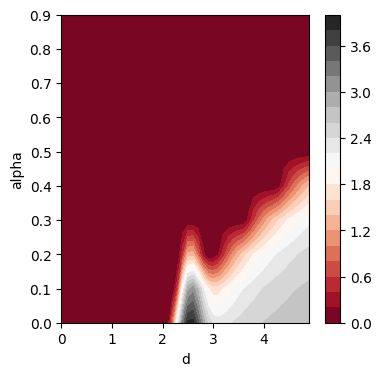

epoch 35 / 500 : loss = 698.6109619140625
epoch 36 / 500 : loss = 694.1345825195312
epoch 37 / 500 : loss = 690.127685546875
epoch 38 / 500 : loss = 686.4879150390625
epoch 39 / 500 : loss = 683.07763671875


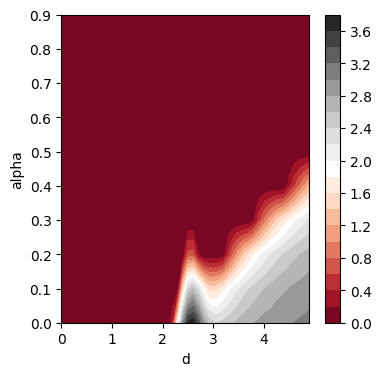

epoch 40 / 500 : loss = 679.8571166992188
epoch 41 / 500 : loss = 676.9342041015625
epoch 42 / 500 : loss = 674.1137084960938
epoch 43 / 500 : loss = 671.3860473632812
epoch 44 / 500 : loss = 668.7549438476562


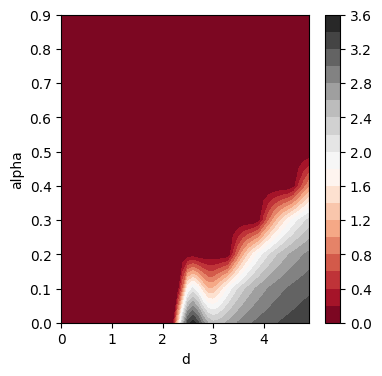

epoch 45 / 500 : loss = 666.1786499023438
epoch 46 / 500 : loss = 663.6723022460938
epoch 47 / 500 : loss = 661.28466796875
epoch 48 / 500 : loss = 659.0460815429688
epoch 49 / 500 : loss = 656.863037109375


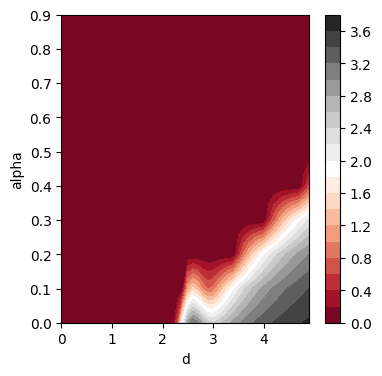

epoch 50 / 500 : loss = 654.689697265625
epoch 51 / 500 : loss = 652.53173828125
epoch 52 / 500 : loss = 650.3807373046875
epoch 53 / 500 : loss = 648.283203125
epoch 54 / 500 : loss = 646.2774047851562


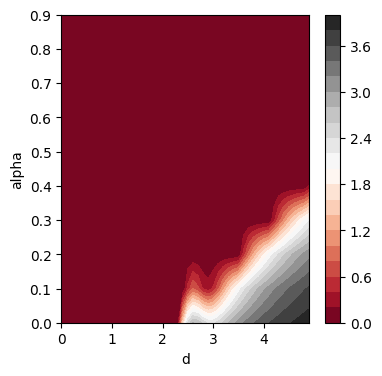

epoch 55 / 500 : loss = 644.2440185546875
epoch 56 / 500 : loss = 642.212158203125
epoch 57 / 500 : loss = 640.258544921875
epoch 58 / 500 : loss = 638.3232421875
epoch 59 / 500 : loss = 636.4569702148438


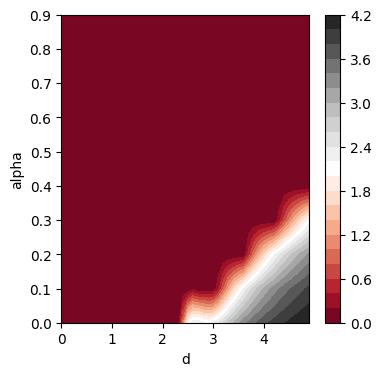

epoch 60 / 500 : loss = 634.6261596679688
epoch 61 / 500 : loss = 632.8442993164062
epoch 62 / 500 : loss = 631.1190185546875
epoch 63 / 500 : loss = 629.4491577148438
epoch 64 / 500 : loss = 627.8222045898438


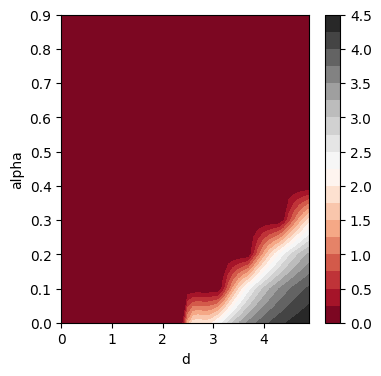

epoch 65 / 500 : loss = 626.2730102539062
epoch 66 / 500 : loss = 624.7066040039062
epoch 67 / 500 : loss = 623.1710205078125
epoch 68 / 500 : loss = 621.6652221679688
epoch 69 / 500 : loss = 620.1668090820312


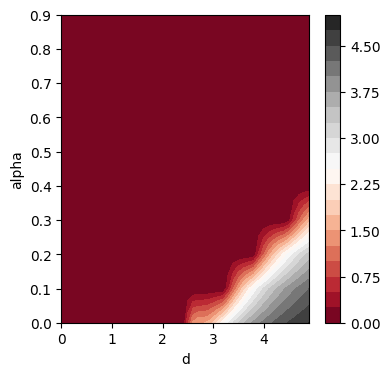

epoch 70 / 500 : loss = 618.7232055664062
epoch 71 / 500 : loss = 617.3113403320312
epoch 72 / 500 : loss = 615.8721313476562
epoch 73 / 500 : loss = 614.451171875
epoch 74 / 500 : loss = 613.0762329101562


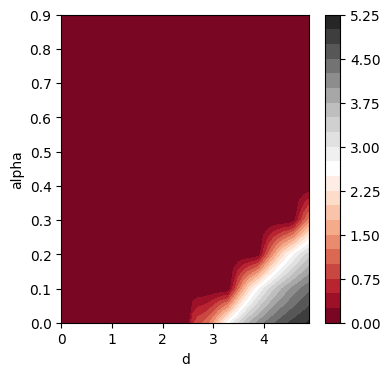

epoch 75 / 500 : loss = 611.7175903320312
epoch 76 / 500 : loss = 610.3626708984375
epoch 77 / 500 : loss = 609.031494140625
epoch 78 / 500 : loss = 607.7593383789062
epoch 79 / 500 : loss = 606.4737548828125


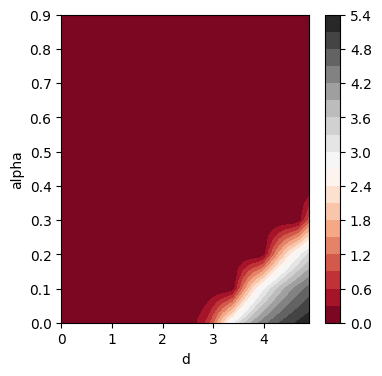

epoch 80 / 500 : loss = 605.170166015625
epoch 81 / 500 : loss = 603.9564819335938
epoch 82 / 500 : loss = 602.759765625
epoch 83 / 500 : loss = 601.5383911132812
epoch 84 / 500 : loss = 600.361083984375


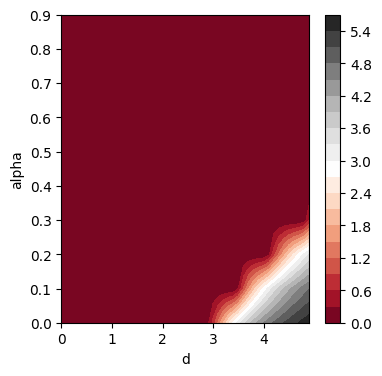

epoch 85 / 500 : loss = 599.2203369140625
epoch 86 / 500 : loss = 598.0637817382812
epoch 87 / 500 : loss = 596.9371948242188
epoch 88 / 500 : loss = 595.8523559570312
epoch 89 / 500 : loss = 594.7875366210938


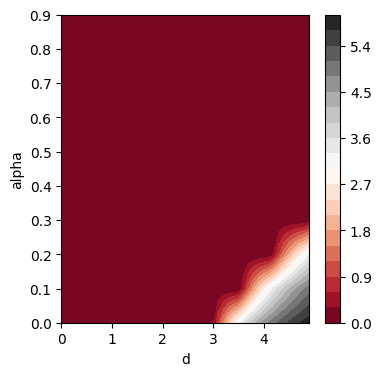

epoch 90 / 500 : loss = 593.7255859375
epoch 91 / 500 : loss = 592.6552124023438
epoch 92 / 500 : loss = 591.6419677734375
epoch 93 / 500 : loss = 590.6522216796875
epoch 94 / 500 : loss = 589.6748046875


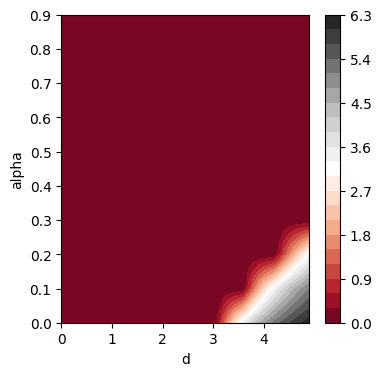

epoch 95 / 500 : loss = 588.6920776367188
epoch 96 / 500 : loss = 587.76513671875
epoch 97 / 500 : loss = 586.8402099609375
epoch 98 / 500 : loss = 585.8968505859375
epoch 99 / 500 : loss = 584.9437255859375


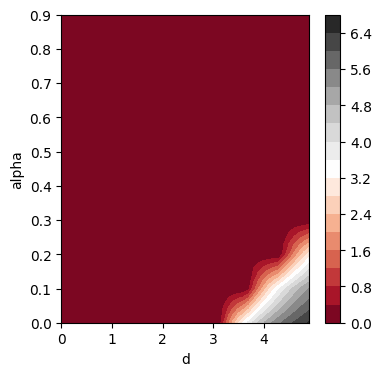

epoch 100 / 500 : loss = 584.0440673828125
epoch 101 / 500 : loss = 583.1813354492188
epoch 102 / 500 : loss = 582.3094482421875
epoch 103 / 500 : loss = 581.4196166992188
epoch 104 / 500 : loss = 580.5458984375


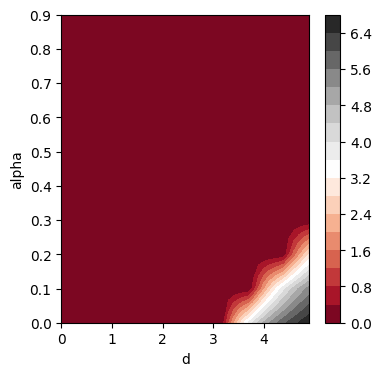

epoch 105 / 500 : loss = 579.664794921875
epoch 106 / 500 : loss = 578.8295288085938
epoch 107 / 500 : loss = 578.0021362304688
epoch 108 / 500 : loss = 577.207275390625
epoch 109 / 500 : loss = 576.3961181640625


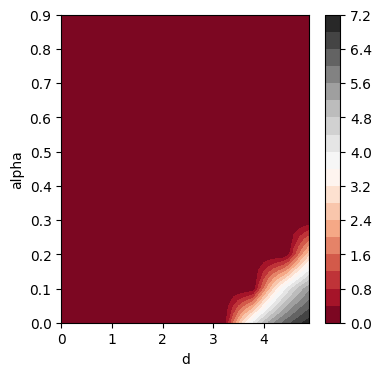

epoch 110 / 500 : loss = 575.5680541992188
epoch 111 / 500 : loss = 574.74951171875
epoch 112 / 500 : loss = 573.9810791015625
epoch 113 / 500 : loss = 573.217041015625
epoch 114 / 500 : loss = 572.4398803710938


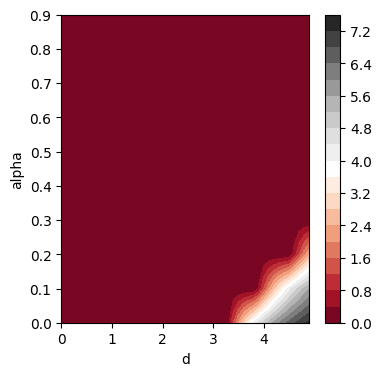

epoch 115 / 500 : loss = 571.6546630859375
epoch 116 / 500 : loss = 570.906982421875
epoch 117 / 500 : loss = 570.17041015625
epoch 118 / 500 : loss = 569.4379272460938
epoch 119 / 500 : loss = 568.7155151367188


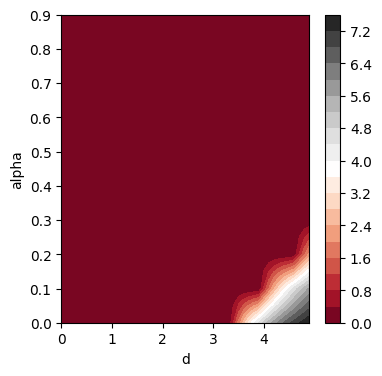

epoch 120 / 500 : loss = 567.9912719726562
epoch 121 / 500 : loss = 567.279541015625
epoch 122 / 500 : loss = 566.5902709960938
epoch 123 / 500 : loss = 565.8964233398438
epoch 124 / 500 : loss = 565.18896484375


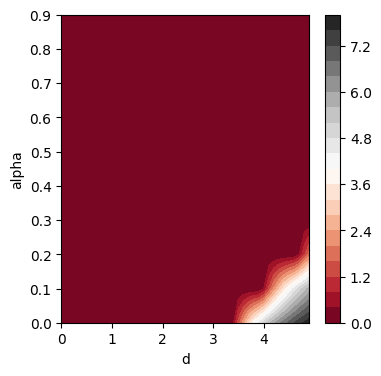

epoch 125 / 500 : loss = 564.537109375
epoch 126 / 500 : loss = 563.8793334960938
epoch 127 / 500 : loss = 563.2230224609375
epoch 128 / 500 : loss = 562.5797729492188
epoch 129 / 500 : loss = 561.9395751953125


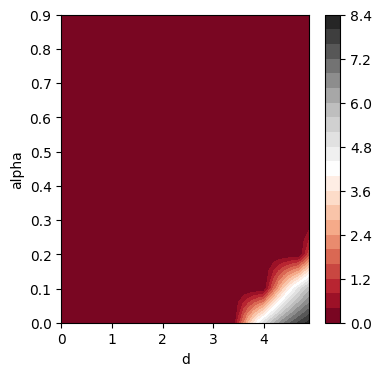

epoch 130 / 500 : loss = 561.3042602539062
epoch 131 / 500 : loss = 560.6646728515625
epoch 132 / 500 : loss = 560.0478515625
epoch 133 / 500 : loss = 559.450927734375
epoch 134 / 500 : loss = 558.896240234375


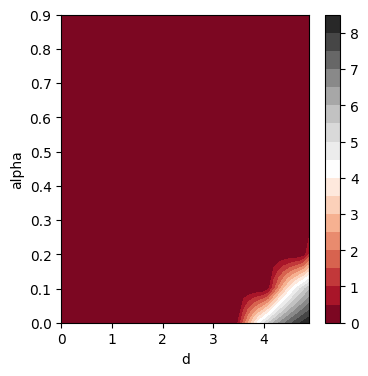

epoch 135 / 500 : loss = 558.3365478515625
epoch 136 / 500 : loss = 557.768310546875
epoch 137 / 500 : loss = 557.1885375976562
epoch 138 / 500 : loss = 556.5971069335938
epoch 139 / 500 : loss = 556.0476684570312


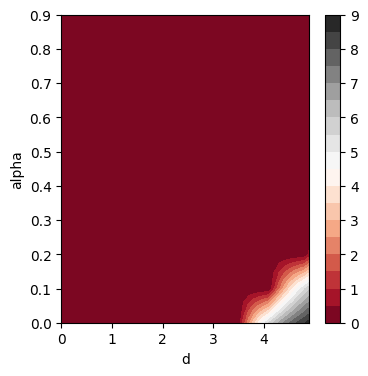

epoch 140 / 500 : loss = 555.530517578125
epoch 141 / 500 : loss = 555.00390625
epoch 142 / 500 : loss = 554.4719848632812
epoch 143 / 500 : loss = 553.9440307617188
epoch 144 / 500 : loss = 553.41748046875


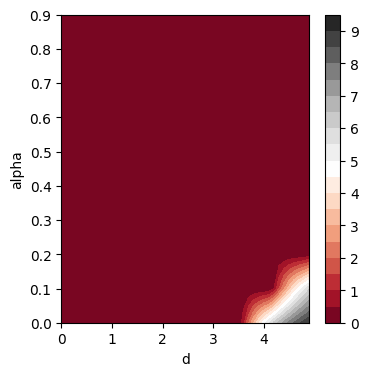

epoch 145 / 500 : loss = 552.8986206054688
epoch 146 / 500 : loss = 552.388427734375
epoch 147 / 500 : loss = 551.8946533203125
epoch 148 / 500 : loss = 551.4052124023438
epoch 149 / 500 : loss = 550.9095458984375


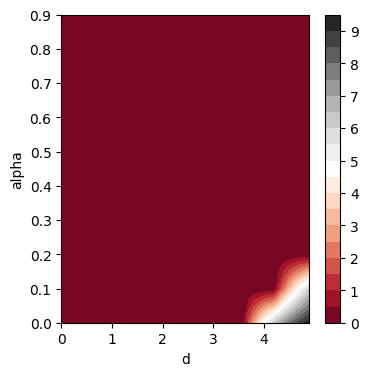

epoch 150 / 500 : loss = 550.4036254882812
epoch 151 / 500 : loss = 549.8983764648438
epoch 152 / 500 : loss = 549.4107666015625
epoch 153 / 500 : loss = 548.925537109375
epoch 154 / 500 : loss = 548.4395751953125


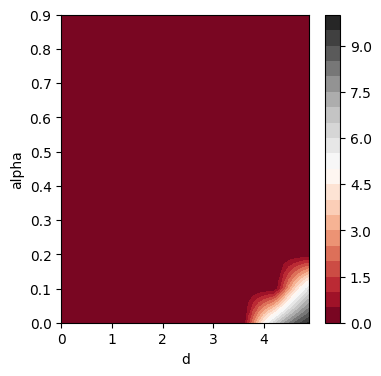

epoch 155 / 500 : loss = 547.9725341796875
epoch 156 / 500 : loss = 547.51513671875
epoch 157 / 500 : loss = 547.0491333007812
epoch 158 / 500 : loss = 546.5971069335938
epoch 159 / 500 : loss = 546.148681640625


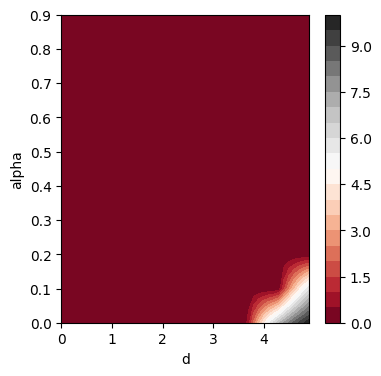

epoch 160 / 500 : loss = 545.6937866210938
epoch 161 / 500 : loss = 545.2301635742188
epoch 162 / 500 : loss = 544.7591552734375
epoch 163 / 500 : loss = 544.2818603515625
epoch 164 / 500 : loss = 543.8447265625


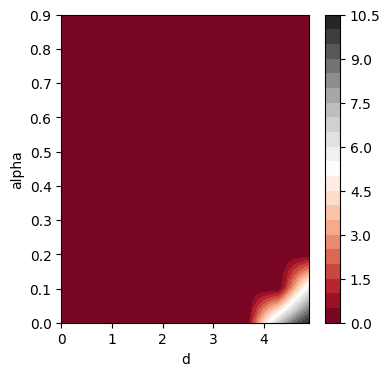

epoch 165 / 500 : loss = 543.4260864257812
epoch 166 / 500 : loss = 543.0079956054688
epoch 167 / 500 : loss = 542.5819091796875
epoch 168 / 500 : loss = 542.1559448242188
epoch 169 / 500 : loss = 541.7274780273438


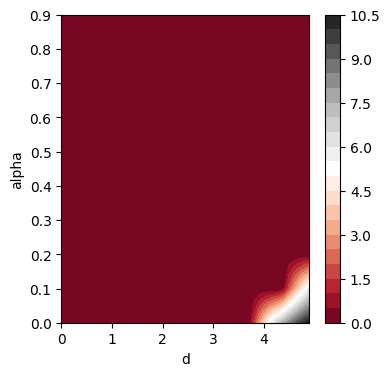

epoch 170 / 500 : loss = 541.291748046875
epoch 171 / 500 : loss = 540.8472290039062
epoch 172 / 500 : loss = 540.4138793945312
epoch 173 / 500 : loss = 540.0150146484375
epoch 174 / 500 : loss = 539.60888671875


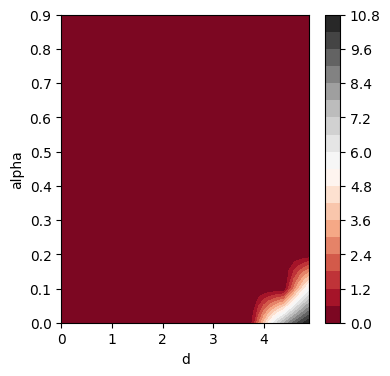

epoch 175 / 500 : loss = 539.2081909179688
epoch 176 / 500 : loss = 538.8106689453125
epoch 177 / 500 : loss = 538.4080810546875
epoch 178 / 500 : loss = 537.9984130859375
epoch 179 / 500 : loss = 537.59326171875


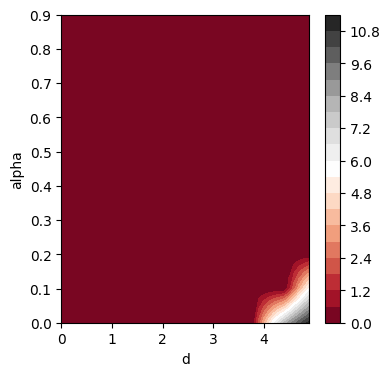

epoch 180 / 500 : loss = 537.204345703125
epoch 181 / 500 : loss = 536.809326171875
epoch 182 / 500 : loss = 536.430908203125
epoch 183 / 500 : loss = 536.059814453125
epoch 184 / 500 : loss = 535.6807250976562


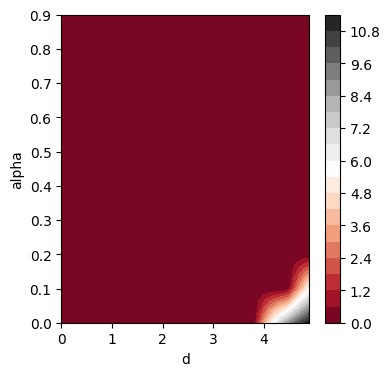

epoch 185 / 500 : loss = 535.2949829101562
epoch 186 / 500 : loss = 534.9027099609375
epoch 187 / 500 : loss = 534.5294799804688
epoch 188 / 500 : loss = 534.1695556640625
epoch 189 / 500 : loss = 533.8054809570312


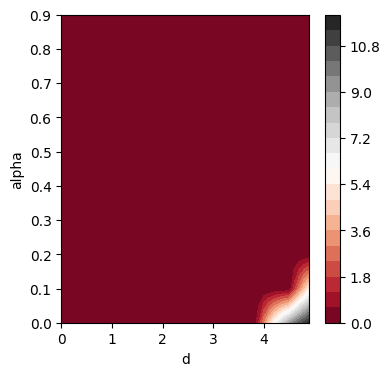

epoch 190 / 500 : loss = 533.4381713867188
epoch 191 / 500 : loss = 533.0718994140625
epoch 192 / 500 : loss = 532.7282104492188
epoch 193 / 500 : loss = 532.38525390625
epoch 194 / 500 : loss = 532.0362548828125


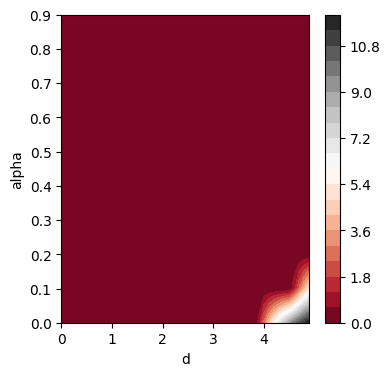

epoch 195 / 500 : loss = 531.7027587890625
epoch 196 / 500 : loss = 531.3733520507812
epoch 197 / 500 : loss = 531.0383911132812
epoch 198 / 500 : loss = 530.69677734375
epoch 199 / 500 : loss = 530.3543701171875


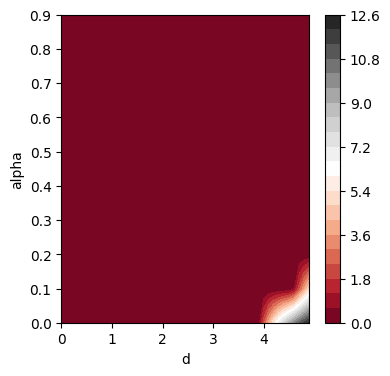

epoch 200 / 500 : loss = 530.0176391601562
epoch 201 / 500 : loss = 529.6781616210938
epoch 202 / 500 : loss = 529.3540649414062
epoch 203 / 500 : loss = 529.050048828125
epoch 204 / 500 : loss = 528.7734985351562


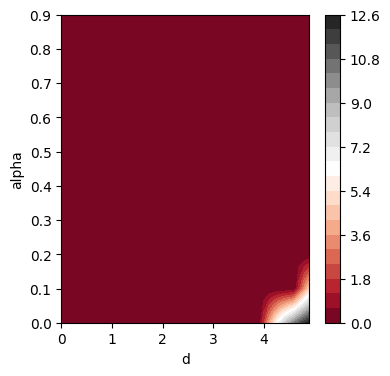

epoch 205 / 500 : loss = 528.4967651367188
epoch 206 / 500 : loss = 528.2156372070312
epoch 207 / 500 : loss = 527.929931640625
epoch 208 / 500 : loss = 527.6389770507812
epoch 209 / 500 : loss = 527.3424682617188


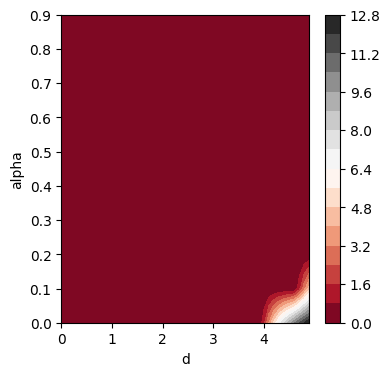

epoch 210 / 500 : loss = 527.0404663085938
epoch 211 / 500 : loss = 526.733642578125
epoch 212 / 500 : loss = 526.4369506835938
epoch 213 / 500 : loss = 526.1767578125


KeyboardInterrupt: 

In [156]:
# train the model
P_alpha_d = train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=500, lr=1e-1)

In [ ]:
P_alpha_d_cpu = P_alpha_d.cpu().detach().numpy()
# normalize P_alpha_d_cpu
# P_alpha_d_cpu = P_alpha_d_cpu / (P_alpha_d_cpu.sum(axis=(1,2), keepdims=True))
print(f"shape of P_alpha_d_cpu : {P_alpha_d_cpu.shape}")
# save P_alpha_d_cpu
np.save("P_alpha_d_cpu.npy", P_alpha_d_cpu)

shape of P_alpha_d_cpu : (100, 10, 50)


In [ ]:
for i in range(0, num_frames, 5):
    # copy P_alpha_d to cpu
    contour_plt(P_alpha_d_cpu, i)

In [ ]:
def give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = np.zeros((num_frames, len(r_vals)))

    # convert P_alpha_d to numpy array
    P_alpha_d = P_alpha_d.cpu().detach().numpy()
    Z = Z.cpu().detach().numpy()
    alpha_vals = alpha_vals.cpu().detach().numpy()
    d_vals = d_vals.cpu().detach().numpy()

    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            integrand = np.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals, axis=1)
            u_pred[i, j] = np.trapz(integrand, alpha_vals)

    # normalize u_pred
    u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True) + 1e-6)
    # u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True))

    # s_vals = np.linspace(0.0, 2*np.pi, 101)
    s_vals = np.linspace(0.0, 10, 101)
    s_vals[0] = 1e-10
    s_vals = s_vals[:-1]

    # get the range of k values
    # convert r_vals to numpy array
    r_vals = r_vals.cpu().detach().numpy()
    k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
    k_vals = fft.fftshift(k_vals)
    # k_vals = 2 * np.pi * k_vals
    # print(k_vals)
    print(f"shape of k_vals : {k_vals.shape}")

    # visualize u_pred
    plt.figure(figsize=(10, 8))
    plt.title("u_pred(s, k) for some s values")
    plt.xlabel("k")
    plt.ylabel("u_pred(s, k)")
    plt.grid()
    for i in range(0, s_vals.shape[0], 10):
        if i == 0:
            continue
        plt.plot(k_vals, u_pred[i, :], label=f"s = {s_vals[i]:.2f}")

    plt.legend()
    plt.show()

shape of k_vals : (500,)


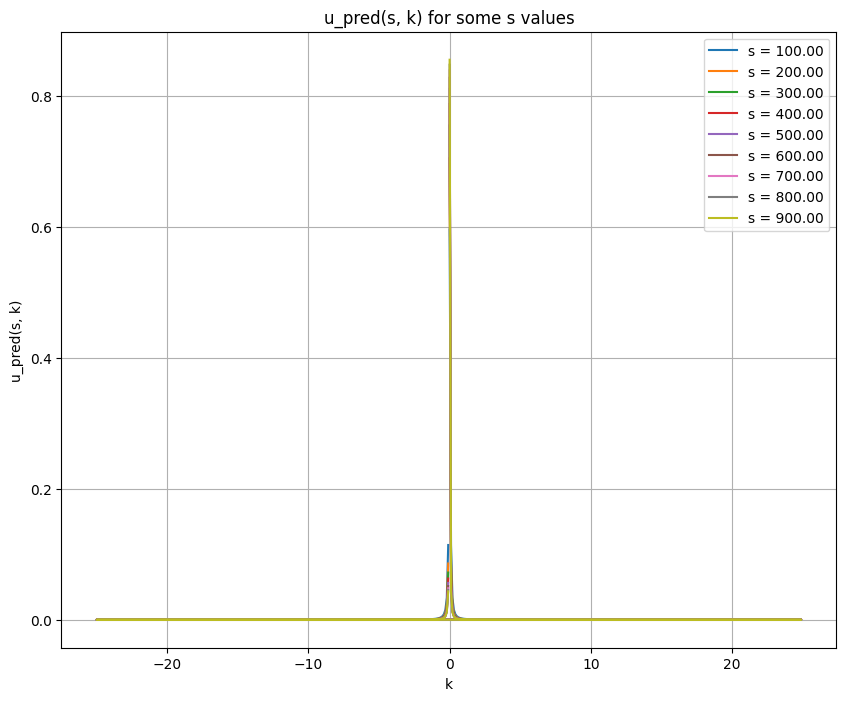

In [ ]:
# reproduce u_pred
give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals)
